<a href="https://colab.research.google.com/github/DigitalBiomarkerDiscoveryPipeline/Case-Studies/blob/main/ECG/Case_Study_ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study
## Validation of HR extracted from consumer wearables against ECG


You own a smartwatch, and you are using it during your physical activity and activities of daily livings. You want to know how well it measures heart rate compared to the “gold standard” electrocardiogram (ECG) data.


# 1. Import libraries

- [numpy](numpy.org): mathematical operations for multi-dimensional arrays and matrices, 
- [pandas](https://pandas.pydata.org/): data analysis tool, operations for numerical tables and time series
- [bioSPPy](https://biosppy.readthedocs.io/en/latest/): signal processing and pattern recognition methods for biosignals
- [heartPy](https://python-heart-rate-analysis-toolkit.readthedocs.io/en/latest/): toolkit mainly designed for PPG data analysis
- [matplotlib](https://matplotlib.org/): toolkit for visualization
- [statsmodels](https://www.statsmodels.org/stable/index.html): functions for statistical tests and statistical models
- [scikit-learn](https://scikit-learn.org/stable/): tools for predictive data analysis
- [scipy](https://scipy.org/): tools for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems
- [mne](https://mne.tools/stable/index.html): Open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more. 
- [seaborn](https://seaborn.pydata.org/): visualization tool for statistical data

In [ ]:
%%capture

# download and unzip dataset
!gdown 1yD-o64q3sPVOSJLZK02Yh-BPViGaWGLl
!unzip 19-002.zip

# install packages
!pip install biosppy
!pip install heartpy
!pip install mne

# download helper function pyscripts

!gdown --id 1ewjd6qUrt9gw2RWKVkHmf35MNcYERIWI
!unzip preprocess.zip

In [ ]:
# import libraries
import pandas as pd
from biosppy.signals import ecg
import heartpy as hp
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy.signal import resample
import seaborn as sns
import preprocess
sns.set_theme(style="whitegrid", palette="colorblind")
pd.options.mode.chained_assignment = None 

# 2. Import data

[STEP dataset](https://github.com/DigitalBiomarkerDiscoveryPipeline/Digital_Health_Data_Repository/tree/main/Cardiovascular/Dataset_STEP) includes heart rate (HR) measurements collected from **six wearable devices** (Apple Watch 4, Fitbit Charge 2, Garmin Vivosmart 3, Xiaomi Midband 3, Empatica E4, and Biovotion Everion) and the raw **ECG** signal data sampled around 1000 Hz.

In this section, we will import the heart rate dataset collected from one participant (19-002).  

## 2.1 Empatica

In [ ]:
empatica_path = './19-002/Empatica'
empatica_data = preprocess.empatica(empatica_path, data_type = "HR")
empatica_data.head()

## 2.2 Apple Watch

In [ ]:
apple_path = './19-002/Apple Watch.csv'
apple_watch_data = preprocess.apple(apple_path)
apple_watch_data.head()

## 2.3 Garmin

In [ ]:
garmin_path = './19-002/garmin.tcx'
garmin_data = preprocess.garmin(garmin_path)
garmin_data.head()

## 2.4 Fitbit

In [ ]:
fitbit_path = './19-002/fitbit.csv'
fitbit_data = preprocess.fitbit(fitbit_path)
fitbit_data.head()

## 2.5 ECG

In [ ]:
ecg_path = './19-002/ECG/ECG.EDF'
ecg_data = preprocess.ecg(ecg_path)

# set sample rate (device specifications)
sample_rate = 1000

# 3. ECG preprocessing

## 3.0 Plot and View ECG

In [ ]:
def plot_ecg_signal(df, title = '', xlabel = '', ylabel = '', zoom = []):
    """Plots ecg signal with an option of zooming into specified time interval.
        Keyword arguments:
        df -- the dataframe containing 'Elapsed_time_(sec)' and '#_ECG' as columns 
        title -- the title for the resulting plot (default '')
        xlabel -- the title for the resulting plot (default '')
        ylabel -- the title for the resulting plot (default '')
        zoom -- a list splecifying the lower and upper limit of the time interval to zoom into [lower, upper] (default [])
        """
    plt.figure(figsize=(12,3))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if len(zoom) > 0:
        zoomed = df.loc[df['Elapsed_time_(sec)'] >= zoom[0]].copy()
        zoomed = zoomed[zoomed['Elapsed_time_(sec)'] <= zoom[1]]
        plt.plot(zoomed['Elapsed_time_(sec)'], zoomed['#_ECG'])
    else:
        plt.plot(df['Elapsed_time_(sec)'], df['#_ECG'])
        
    plt.xlim(left=0)


In [ ]:
plot_ecg_signal(ecg_data, 
                title = 'Unfiltered ECG Data', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV')

## 3.1 Cut out noisy ends

The start and the end of the ECG data may contain motion artifacts, leading the signal to be too noisy. If necessary, we will ignore these noisy parts out by eliminating them from our signal. 

In [ ]:
# Cut the start and end by specifying the time interval to keep
# Of note, this step will overwrite the ecg_data. To revert, rerun the ECG import cell.

# time_interval = [lower, upper] -- Replace the the lower and upper values from the time_interval variable
# time_interval = [0, int(len(ecg_data)/sample_rate)]
time_interval = [0, 2800]

ecg_data = ecg_data.iloc[(time_interval[0]*sample_rate):(time_interval[1]*sample_rate)]


In [ ]:
# Replot the signal
plot_ecg_signal(ecg_data, 
                title = 'Unfiltered ECG Data', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV')

In [ ]:
# Using the zoom feature of the plotting function
# Replace the [lower, upper] bounds of the time interval to zoom into

plot_ecg_signal(ecg_data, 
                title = 'Unfiltered ECG Data (Zoomed to show first 10 seconds)', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV', zoom = [0, 10])

In [ ]:
# Run heart rate signal peak detection 

wd, m = hp.process(ecg_data['#_ECG'], sample_rate)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)


In [ ]:
# We can also look into specific sections for heart rate signal peak detection. 
# Run heart rate signal peak detection for the first 10 seconds.

# time_interval = [lower, upper] -- Replace the the lower and upper values from the time_interval variable
time_interval = [0,10]

wd, m = hp.process(ecg_data['#_ECG'][time_interval[0]*sample_rate : time_interval[1]*sample_rate], 
                   sample_rate)

plt.figure(figsize=(12,4))
hp.plotter(wd, m)


## 3.2 Baseline Wander Filter

Baseline wander is a "**low frequency** artifact (i.e. 
noise) that arises from breathing, electrically charged electrodes, or subject movement and can hinder the detection of these ST changes." While baseline wander may be located at higher frequencies, it is recommended as standard practice to design the baseline wander filter with a maximum cutoff frequency at 0.05 Hz. 

> *Lenis, G., Pilia, N., Loewe, A., Schulze, W. H., & Dössel, O. (2017). Comparison of Baseline Wander Removal Techniques considering the Preservation of ST Changes in the Ischemic ECG: A Simulation Study. Computational and mathematical methods in medicine, 2017, 9295029. https://doi.org/10.1155/2017/9295029*



In [ ]:
# create a copy of the ecg_data
filtered = ecg_data.copy()

# apply baseline wander filter with a specified cutoff frequecy (defaulted to 0.05)
filtered["#_ECG"] = hp.remove_baseline_wander(ecg_data['#_ECG'], sample_rate, cutoff = 0.05)

# plot the filtered signal
plot_ecg_signal(ecg_data, 
                title = 'Unfiltered ECG Data', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV', zoom = [0, 10])
# plot the filtered signal zoomed to 0 to 10 seconds
plot_ecg_signal(filtered, 
                title = 'Filtered ECG Data (First 10 Seconds)', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV', zoom = [0, 10])


In [ ]:
# Run heart rate signal peak detection on entire signal
wd, m = hp.process(filtered["#_ECG"], sample_rate)
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

# Run heart rate signal peak detection for the first 10 seconds.
# time_interval = [lower, upper] -- Replace the the lower and upper values from the time_interval variable
time_interval = [0,10]

wd, m = hp.process(filtered["#_ECG"][time_interval[0]*sample_rate : time_interval[1]*sample_rate], 
                   sample_rate)
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

## 3.3 (Optional) Bandpass filter

Bandpass filter is designed to surpress freuqencies that are outside the specified **cutoff interval**, specified by a lower and upper threshold. 

*   **Remove low frequency:** 
*   **Remove high frequency:** From literature, it is recommended to have "an upper-frequency cutoff of at least **150 Hz**" for adults. 
* The **order** of the bandpass filter can also be specified to adjust the width of the filter (narrow or wide). https://www.electronics-tutorials.ws/filter/filter_8.html

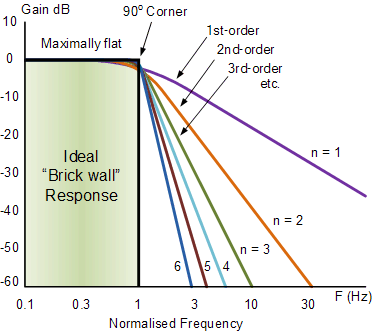


>Kligfield, P., Gettes, L. S., Bailey, J. J., Childers, R., Deal, B. J., Hancock, E. W., van Herpen, G., Kors, J. A., Macfarlane, P., Mirvis, D. M., Pahlm, O., Rautaharju, P., Wagner, G. S., American Heart Association Electrocardiography and Arrhythmias Committee, Council on Clinical Cardiology, American College of Cardiology Foundation, Heart Rhythm Society, Josephson, M., Mason, J. W., Okin, P., Surawicz, B., … Wellens, H. (2007). Recommendations for the standardization and interpretation of the electrocardiogram: part I: The electrocardiogram and its technology: a scientific statement from the American Heart Association Electrocardiography and Arrhythmias Committee, Council on Clinical Cardiology; the American College of Cardiology Foundation; and the Heart Rhythm Society: endorsed by the International Society for Computerized Electrocardiology. Circulation, 115(10), 1306–1324. https://doi.org/10.1161/CIRCULATIONAHA.106.180200




In [ ]:
temp = hp.filter_signal(filtered["#_ECG"], 
                                     cutoff = [0.05,150], 
                                     sample_rate = sample_rate, 
                                     filtertype='bandpass')

In [ ]:
# create a copy

filtered_2 = filtered.copy()
filtered_2["#_ECG"] = temp

# Plot the filtered signal zoomed to 0 to 10 seconds
plot_ecg_signal(filtered_2, 
                title = 'Filtered ECG Data (First 10 Seconds)', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV', zoom = [0, 10])


# Run heart rate signal peak detection on entire signal
wd, m = hp.process(temp, sample_rate)
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

# Run heart rate signal peak detection for the first 10 seconds.
# time_interval = [lower, upper] -- Replace the the lower and upper values from the time_interval variable
time_interval = [0,10]

wd, m = hp.process(temp[time_interval[0]*sample_rate : time_interval[1]*sample_rate], 
                   sample_rate)
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

In [ ]:
# If you like what yous see, save the filtered signal!
filtered["#_ECG"] = temp

In [ ]:
plot_ecg_signal(filtered, 
                title = 'Filtered ECG Data', 
                xlabel = 'Elapsed time (sec)', 
                ylabel = 'ECG in mV')


# 4. ECG Heart Rate Extraction

In [ ]:
data = filtered['#_ECG'].values

In [ ]:
segment_width = 10
wd, m = hp.process_segmentwise(data, sample_rate, segment_width= segment_width, segment_overlap= 0, 
                                   replace_outliers = True, mode = 'full', outlier_method = 'iqr', bpmmax = 120)

In [ ]:
ecg_HR = pd.DataFrame({'HR_ecg': m['bpm']})
ecg_HR['Elapsed_time_(sec)'] = (np.array(ecg_HR.index) + 1) * segment_width
ecg_HR['HR_ecg'] = ecg_HR['HR_ecg'].fillna(method = 'ffill')

In [ ]:
ecg_HR.head()

In [ ]:

ecg_HR.plot(x = 'Elapsed_time_(sec)', y = 'HR_ecg',figsize=(12,4))

# 5. Resample all heart rate data
For fair comparison, we will resample each modalities in k seconds, either performing linear interpolation or simple forward filling the missing values.

In [ ]:
# specify the resampling time k -- here, we want our dataframe to have values for each second
# specify whether to interpolate the missing value or carry forward last known value
k = 1

resampled_empatica = preprocess.resample_and_interpolate(empatica_data, interpolate_col = 'HR_Empatica', resample_step = k, interpolate = False)
resampled_apple = preprocess.resample_and_interpolate(apple_watch_data, interpolate_col = 'HR_Apple', resample_step = k, interpolate = False)
resampled_garmin = preprocess.resample_and_interpolate(garmin_data, interpolate_col = 'HR_Garmin', resample_step = k, interpolate = False)
resampled_fitbit = preprocess.resample_and_interpolate(fitbit_data, interpolate_col = 'HR_Fitbit', resample_step = k, interpolate = False)
resampled_ecg = preprocess.resample_and_interpolate(ecg_HR, interpolate_col = 'HR_ecg', resample_step = k, interpolate = False)


# 6. Visualization

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
modalities = [ecg_HR, apple_watch_data, empatica_data, fitbit_data, garmin_data]
modalities = [resampled_ecg, resampled_apple, resampled_empatica, resampled_fitbit, resampled_garmin]
max_time = ecg_HR['Elapsed_time_(sec)'].max()
for i, watch_type in enumerate(modalities):
    x = watch_type['Elapsed_time_(sec)']
    y = watch_type.filter(regex='HR')
    axes[i].plot(x.values, y.values)
    axes[i].scatter(x.values, y.values, alpha = 0.3)
    axes[i].set_xlabel('Elapsed_time_(sec)')
    axes[i].set_ylabel('Estimated Heart Rate (BPM)')
    axes[i].set_title(y.columns[0])
    axes[i].set_ylim([40,180])
    axes[i].set_xlim(xmin=0)
    plt.xlim(left=0)
    
fig.tight_layout()

# 7. Time Alignment

In [ ]:
all_HR = resampled_ecg.copy()
all_HR = all_HR.merge(resampled_apple, on = 'Elapsed_time_(sec)', how = 'outer')
all_HR = all_HR.merge(resampled_empatica, on = 'Elapsed_time_(sec)', how = 'outer')
all_HR = all_HR.merge(resampled_garmin, on = 'Elapsed_time_(sec)', how = 'outer')
all_HR = all_HR.merge(resampled_fitbit, on = 'Elapsed_time_(sec)', how = 'outer')

watches = ['HR_Apple', 'HR_Empatica', 'HR_Garmin', 'HR_Fitbit']

# specify the values to be shifted (positive = to the right, negative = to the left)
apple_shift = 490
empatica_shift = -550
garmin_shift = 1880
fitbit_shift = 800

annotate_rest = 0
annotate_paced_breathing = 250
annotate_physical_activity = 500
annotate_washout = 800

shifts = [apple_shift, empatica_shift, garmin_shift, fitbit_shift]

arrowprops = {'width': 0.5, 'linewidth': 1, 'headwidth': 1, 'headlength': 1, 
              'shrink':0.05 , 'color': 'grey', 'alpha': 0.5, 'linestyle': '--'}

{'-',}

for j, i in enumerate(watches): 
    
    all_HR_temp = all_HR.copy()
    all_HR_temp[i] = all_HR_temp[i].shift(shifts[j])
    ax = all_HR_temp.plot(x = 'Elapsed_time_(sec)', y = 'HR_ecg',
               figsize = (15,4), alpha = 0.6, grid = True, color = 'grey')
    all_HR_temp.plot(x = 'Elapsed_time_(sec)', y = i,
               figsize = (15,4), alpha = 0.8, grid = True, color = 'red', ax = ax)
    ymin, ymax = plt.ylim()

    plt.annotate('Rest', xy =(annotate_rest, ymin),
                xytext=(annotate_rest, ymax), rotation=90, va='bottom', ha='center', annotation_clip=False, arrowprops=arrowprops)

    plt.annotate('Paced\nBreathing', xy =(annotate_paced_breathing, ymin),
                xytext =(annotate_paced_breathing, ymax), rotation=90, va='bottom', ha='center', annotation_clip=False, arrowprops=arrowprops)

    plt.annotate('Activity', xy =(annotate_physical_activity, ymin),
                xytext =(annotate_physical_activity, ymax), rotation=90, va='bottom', ha='center', annotation_clip=False, arrowprops=arrowprops)

    plt.annotate('Washout', xy =(annotate_washout, ymin),
                xytext = (annotate_washout, ymax),rotation=90, va='bottom', ha='center', annotation_clip=False, arrowprops=arrowprops)


In [ ]:
# If you like what you see, make the shifts permanent!

for j, i in enumerate(watches): 
    all_HR[i] = all_HR[i].shift(shifts[j])

In [ ]:
all_HR

In [ ]:
# (optional) Manual cutoff if needed
# If you look closely, fitbit has a long static  measurement. 
# This can be removed by setting the cutoff interval.

time_interval = [1800, 2789]

mask = (all_HR['Elapsed_time_(sec)'] <= time_interval[0]) | (all_HR['Elapsed_time_(sec)'] >= time_interval[1])
all_HR.loc[mask, "HR_Fitbit"] = np.nan

In [ ]:
# drop all rows that do not have the ecg value reported
all_HR = all_HR.dropna(subset = ['HR_ecg'])

# 8. Comparison

## 8.1 Error Calculation
We will look into the directional error (DE) and the absolute error (AE) of HR measurements as defined by https://www.nature.com/articles/s41746-020-0226-6#Sec10. 


In [ ]:
de = all_HR.copy()

for col in de.filter(regex='HR'):
    de[col] = de[col]-all_HR['HR_ecg']

de = de.drop(['Elapsed_time_(sec)', 'HR_ecg'], axis = 1)

ae = abs(de.copy())


In [ ]:
de.describe()

In [ ]:
ae.describe()

In [ ]:

plt.figure(figsize = (8,8))
box_plot  = sns.boxplot(data = de).set(
    xlabel='Wearable Devices', 
    ylabel='Directional Error (MDE)'
)


In [ ]:

plt.figure(figsize = (8,8))
box_plot  = sns.boxplot(data = ae).set(
    xlabel='Wearable Devices', 
    ylabel='Absolute Error (AE)'
)


## 8.2 Correlation Plot

In [ ]:
corr_with_HR_ECG = all_HR.corr(method ='pearson').loc['HR_ecg']
all_HR.corr(method ='pearson')

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
axes = [ax1, ax2, ax3, ax4]

i = 0
for col in all_HR.filter(regex='HR'):
    if col == 'HR_ecg':
        pass
    else:
        temp = all_HR[['HR_ecg', col]].dropna()
        x = temp['HR_ecg'].values
        y = temp[col].values
        sns.regplot(x='HR_ecg', y =col, data =temp, ax = axes[i], color = sns.color_palette('colorblind')[i])
        axes[i].set_title(col[3:]+ ' (r-value: {:.3f})'.format(corr_with_HR_ECG[col]))
        i +=1


## 8.3 Bland-Altman Plot

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))
axes = [ax1, ax2, ax3, ax4]

i = 0
for col in all_HR.filter(regex='HR'):
    if col == 'HR_ecg':
        pass
    else:
        sm.graphics.mean_diff_plot(all_HR['HR_ecg'], all_HR[col], 
                                   ax = axes[i], 
                                   scatter_kwds = {'c': sns.color_palette("colorblind")[i]})
        
        axes[i].set_title('Bland-Altman Plot for ECG/' + col[3:])
        i+=1
